# Test for autoencoder models
* find out how good they are in separating features by labels

In [2]:
import os

import torch
import torchvision
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
import math 
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using mps device


In [4]:
torch.manual_seed(10)

In [5]:
def to_img(x):
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    x = x.view(x.size(0), 1, 28, 28)
    return x

In [34]:
class conv_autoencoder(nn.Module):
    def __init__(self):
        super(conv_autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=3, padding=1),  # b, 16, 10, 10
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=2),  # b, 16, 5, 5
            nn.Conv2d(16, 10, 3, stride=2, padding=1),  # b, 10, 3, 3
            nn.ReLU(True),
            nn.Conv2d(10, 1, 3, stride=2, padding=1),  # b, 1, 2, 2
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=1)  # b, 1, 1, 1
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(1, 16, 5, stride=2, padding=0),  # b, 16, 5, 5
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 5, stride=3, padding=1),  # b, 8, 15, 15
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 2, stride=2, padding=1),  # b, 1, 28, 28
            nn.Tanh()
        )

    def forward(self, x):
        code = self.encoder(x)
        output = self.decoder(code)
        return code, output

# Load model from file
model = conv_autoencoder()
model_file =  '../conv_autoencoder_1o.pth'
model.load_state_dict(torch.load(model_file))

num_params = sum(p.numel() for p in model.parameters())
print(f'Number of parameters: {num_params}')

Number of parameters: 5358


In [35]:
# MNIST data

img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

batch_size = 1000

dataset = MNIST('./data', transform=img_transform, download=False)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


In [36]:
from collections import defaultdict

data = defaultdict(list)

In [37]:
# predict
for input_data in dataloader:
    img, label = input_data
     #img = img.view(img.size(0), -1)
    with torch.no_grad():
        code, output = model(img)
        code = code.squeeze()
    
    for i in range(label.shape[0]):
        data[label[i].item()].append(code[i].item())

0 2.3321889137952048 2.638039389981234
1 43.02591133704705 19.55582154225114
2 4.576447566350301 4.352838460607335
3 5.446707495544887 5.141452276868636
4 8.29721610395519 3.704865865579028
5 7.611573882855914 6.450969800494335
6 4.8566744468348295 7.871252107570719
7 9.452910132914282 3.4249814199484
8 10.407703900822124 7.51673211185266
9 8.416747658167353 3.6509042214128713


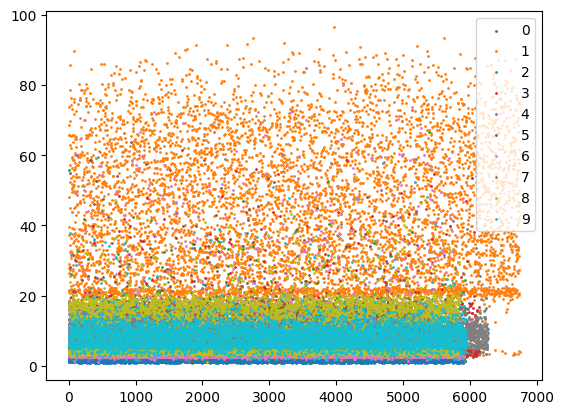

In [38]:
code_mean = []
code_std = []
for i in range(0,10):
    plt.scatter(range(len(data[i])), data[i], label=i, s=1)
    code_mean.append(np.mean(data[i]))
    code_std.append(np.std(data[i]))
    print(i, code_mean[i], code_std[i])


plt.legend()
plt.show()

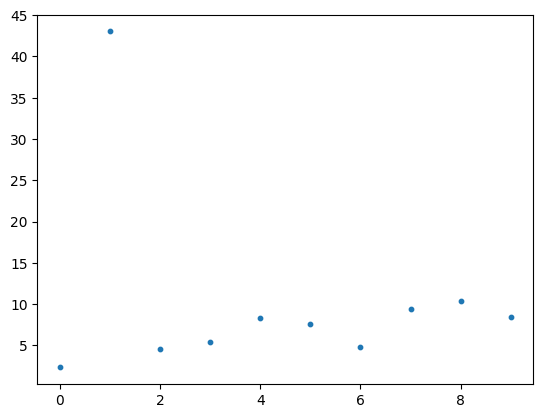

In [41]:
plt.scatter(np.arange(0,10), code_mean[0:10], s=10)

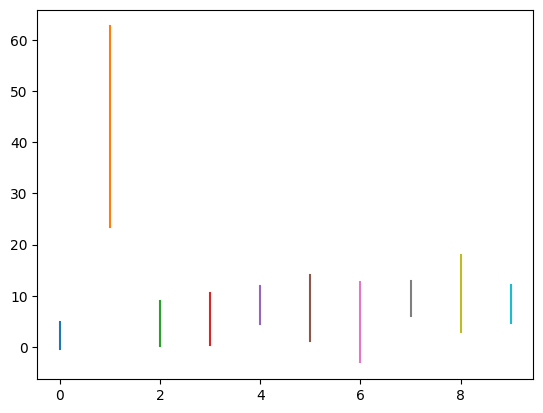

In [42]:
for i in range(0,10):
    x = [i,i]
    y = [code_mean[i]-code_std[i], code_mean[i]+code_std[i]]
    plt.plot(x,y,label=i)

# END
* DEBUG below

In [45]:
input_tensor = torch.randn(128, 1, 28, 28)  # Example input tensor
conv = torch.nn.Conv2d(1, 16, 3, stride=3, padding=1)
output = conv(input_tensor)
print(output.shape) # torch.Size([128, 16, 10, 10])

torch.Size([128, 16, 10, 10])


In [56]:
maxp = nn.MaxPool2d(2, stride=2)  # b, 16, 5, 5
maxp_out = maxp(output)
print(maxp_out.shape)
conv2 = nn.Conv2d(16, 10, 3, stride=2, padding=1)
output2 = conv2(maxp_out)
print(output2.shape) 
conv3 = nn.Conv2d(10, 10, 3, stride=2, padding=0)
output3 = conv3(output2)
print(output3.shape) 
flat = nn.Flatten(start_dim=1)
flat_out = flat(output3)
print(flat_out.shape)
#maxp2 = nn.MaxPool2d(2, stride=1)
#maxp2_out = maxp2(output3)
#print(maxp2_out.shape)

torch.Size([128, 16, 5, 5])
torch.Size([128, 10, 3, 3])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10])


In [24]:
import torch

input_tensor = torch.randn(128, 1, 1, 1)  # Example input tensor
conv_transpose = torch.nn.ConvTranspose2d(1, 16, 5, stride=1, padding=0)
output_shape = conv_transpose(input_tensor).shape
print(output_shape)  # torch.Size([128, 16, 3, 3])

torch.Size([128, 16, 5, 5])


In [165]:
input_tensor = torch.randn(128, 16, 5, 5)  # Example input tensor
conv_transpose = torch.nn.ConvTranspose2d(16, 8, 5, stride=3, padding=1)
output_shape = conv_transpose(input_tensor).shape
print(output_shape)  # torch.Size([128, 8, 11, 11])

torch.Size([128, 8, 15, 15])


In [166]:
input_tensor = torch.randn(128, 8, 15, 15)  # Example input tensor
conv_transpose = torch.nn.ConvTranspose2d(8, 1, 2, stride=2, padding=1)
output_shape = conv_transpose(input_tensor).shape
print(output_shape)  # torch.Size([128, 1, 16, 16])

torch.Size([128, 1, 28, 28])


In [57]:
input_tensor = torch.randn(128, 10)  # Example input tensor
conv = nn.Conv2d(10, 16, 1, stride=1, padding=2)
output = conv(input_tensor.unsqueeze(-1).unsqueeze(-1))
print(output.shape)

torch.Size([128, 16, 5, 5])
